In [ ]:
# Required for Google Colab!

from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio
!pip install xarray
!pip install zarr

import os

# Root of project
os.chdir('/content/drive/MyDrive/Final Submission Files')

# Improvements folder
os.chdir('Models/Improvements')

Mounted at /content/drive


In [ ]:
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy import stats
import pandas as pd
from xgrid_utils import calc_spatial_integral

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [ ]:
# Re-projection (and plot) (note that we do not use the re-projected data in our model)
ds = xr.open_zarr('/content/drive/MyDrive/SYDE 675/Project/Data/era5_monthly.zarr')

ds.isel(time=-8).t2m.plot(figsize=(16, 4))
ds.isel(time=-8).siconc.plot(figsize=(16, 4))

ds_polar = ds.rio.write_crs(4326).rio.reproject(3995)
ds_polar = xr.open_dataset('../data/era5_monthly_polar_resampled.zarr').drop(['spatial_ref'])

ds_polar.isel(time=-8).t2m.plot(figsize=(8, 6))
ds_polar.isel(time=-8).siconc.plot(figsize=(8, 6))

In [ ]:
# Calculate SIE using area-weighted mean
extents = calc_spatial_integral(ds.siconc > 0.15) / 1000**2  # SIE in km2

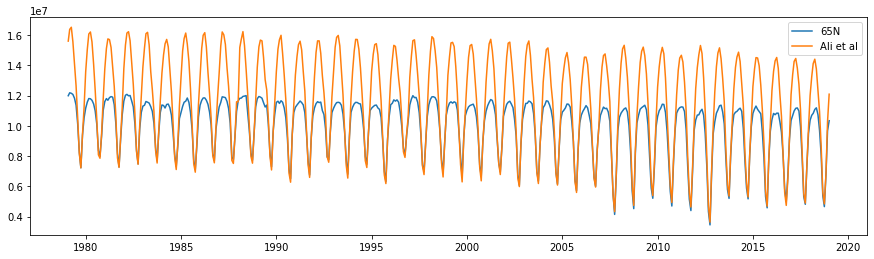

In [ ]:
# Compare Ali's extents to ours (Ali = 25N)
extents_ali = np.load('/content/drive/MyDrive/SYDE 675/Project/Data/monthly_target.npy', allow_pickle=True)
month_range = pd.date_range(datetime.datetime(1979, 1, 1), datetime.datetime(2019, 1, 1), freq='M')

plt.figure(figsize=(15, 4))
plt.plot(np.array(ds.time), np.array(extents), label='65N')
plt.plot(month_range, extents_ali, label='Ali et al')
plt.legend()

In [ ]:
ds_norm = (ds - ds.mean())/ds.std()  # Normalize
ds_norm_coarsened = ds_norm.coarsen({'latitude': 4, 'longitude': 4}, boundary='trim').mean()  # Resample by factor of 4

Text(0.5, 1.0, 'Original SIE')

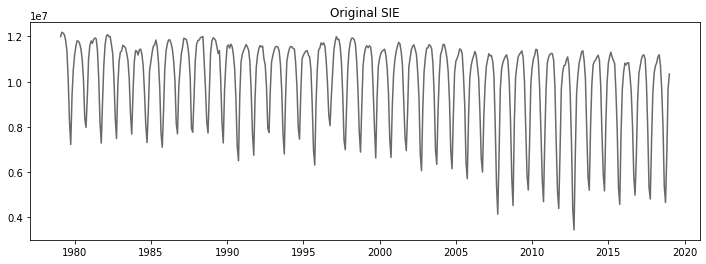

In [ ]:
# Plot original data
plt.figure(figsize=(12, 4))
plt.plot(dates, extents, 'dimgrey')
plt.title('Original SIE')

(480,)
DataArrayGroupBy, grouped over 'year'
40 groups with labels 1979, 1980, 1981, ..., 2017, 2018.
[1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


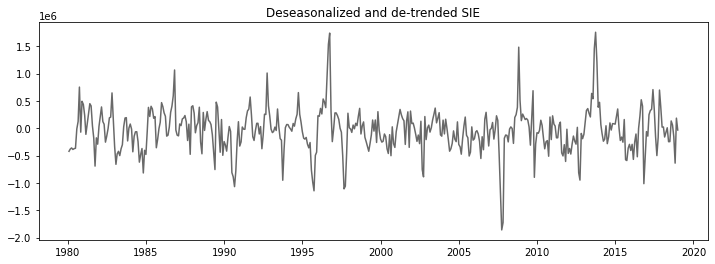

In [ ]:
# De-seasonalize and de-trend the SIE data
y_extent = extents
dates = ds.time

# Use 'all' to deseasonalize using the entire dataset (i.e. use deseasonalize())
# Use some integer to use the past n years (i.e. use deseasonalize_recent())
deseasonalize_type = 1  # 'all'

def deseasonalize(y, dates):
    """Deseasonalize y by subtracting the monthly means"""
    y = xr.DataArray(y, dims=['time'], coords={'time': dates})  # Create time-aware array
    climatologies = y.groupby('time.month').mean()  # Get monthly means
    y = (y.groupby('time.month') - climatologies).values  # Subtract monthly means
    return y

def deseasonalize_recent(y, dates, past_n_years=1):
    """Deseasonalize y by subtracting the monthly means of the previous n years"""
    y = xr.DataArray(y, dims=['time'], coords={'time': dates})  # Create time-aware array
    print(y.shape)

    # Group y by year and store years
    y_years = y.groupby('time.year')
    print(y_years)
    years = sorted(y_years.groups.keys())
    print(years)

    # Loop over each year, starting at (past_n_years), deseasonalize, and append
    # i.e. for past_n_years, use the first two to deseasonalize the third, and so on
    #
    # [xx+oooooooo]  
    # [oxx+ooooooo]
    # [ooxx+oooooo]
    # where xx are used to find climatology, and + is being deseasonalized

    y_deseasonalized = []  # List of deseasonalized yearly data
    for i in range(past_n_years, len(years)):
        climatologies = xr.concat(
            [y_years[year] for year in years[i - past_n_years: i]],
            dim='time').groupby('time.month').mean()
        y_deseasonalized.append(y_years[years[i]].groupby('time.month') - climatologies)

    y_deseasonalized = xr.concat(y_deseasonalized, dim='time')
    dates = y_deseasonalized.time
    y = np.array(y_deseasonalized)
    return y, dates

def detrend(y, dates):
    """Remove a linear trend from y"""
    slope, intercept, r, p, se = stats.linregress(dates.astype(int), list(y))
    y = np.array(y - (intercept + slope * dates.astype(int)))
    return y

if deseasonalize_type == 'all':
    y_extent, dates = deseasonalize(y_extent, dates)

    # Plot with trend
    slope, intercept, r, p, se = stats.linregress(dates.astype(int), list(y_extent))
    plt.figure(figsize=(12, 4))
    plt.plot(dates, y_extent, 'dimgrey')
    plt.plot(dates, intercept + slope * dates.astype(int), 'k--')
    plt.title('Deseasonalized SIE (with downward trend)')

    # Remove trend
    y_extent = detrend(y_extent, dates)
        
    # Plot without trend
    plt.figure(figsize=(12, 4))
    plt.plot(dates, y_extent, 'dimgrey')
    plt.title('Deseasonalized and de-trended SIE')

else:
    y_extent, dates = deseasonalize_recent(y_extent, dates)

    # Plot without seasons + trend
    plt.figure(figsize=(12, 4))
    plt.plot(dates, y_extent, 'dimgrey')
    plt.title('Deseasonalized and de-trended SIE')

In [ ]:
# Train-test split and timestep creation
# NOTE: We must assume deseasonalize_type * 12 > num_timesteps. Otherwise modify this code.

test_size = 0.2

# Find year corresponding to a split at (test_size)% 
split_year = dates[int(len(y_extent) * (1 - test_size))].dt.year.values.item()

# Find index of the first month of that year, at which we will split
split_index = np.argwhere(np.array(dates.dt.year).flatten() > split_year)[0][0]

# Split the dates using the split_index
dates_train = dates[:split_index]
dates_test = dates[split_index:]

# Split y extents using the same index
y_extent_train = y_extent[:split_index]
y_extent_test = y_extent[split_index:]

# Standardize y_extent
extent_scaler = StandardScaler()
y_extent_train = extent_scaler.fit_transform(y_extent_train.reshape(-1, 1)).flatten()
y_extent_test = extent_scaler.transform(y_extent_test.reshape(-1, 1)).flatten()

# Create X extents from the standardized y_extents
X_extent_train = create_timesteps(y_extent_train, num_timesteps).T[:-1]
X_extent_test = create_timesteps(y_extent_test, num_timesteps).T[:-1]


# Split X gridded
# Remove first few years of X_grid data coinciding with the number of timesteps (assumes data starts on January of first year)
if deseasonalize_type != 'all':
    # Train:
    # Start index is the number of years skipped due to deseasonalizing
    # End index is the split index PLUS the number of years skipped MINUS the number of timesteps in X 
    # X_grid_train = X_grid[deseasonalize_type * 12: split_index + deseasonalize_type * 12 - num_timesteps]
    X_grid_train = X_grid[deseasonalize_type * 12: ]
    X_grid_train = X_grid_train[ :split_index - num_timesteps]

    # Test:
    # Start index is the split index PLUS the number of years skipped due to deseasonalizing
    # End index is the number of timesteps in X (from the end)
    X_grid_test = X_grid[split_index + deseasonalize_type * 12: -num_timesteps]
else:
    raise NotImplementedError('TODO')
    # X_grid_train = X_grid[: num_timesteps + split_index - 1]
    # X_grid_test = X_grid[num_timesteps + split_index: -1]

# Since we are predicting y_extent from (num_timesteps) on
y_extent_train = y_extent_train[num_timesteps:]
y_extent_test = y_extent_test[num_timesteps:]
dates_train = dates_train[num_timesteps:]
dates_test = dates_test[num_timesteps:]

print('Train:')
print(X_grid_train.shape)
print(X_extent_train.shape)
print(y_extent_train.shape)

print('Test:')
print(X_grid_test.shape)
print(X_extent_test.shape)
print(y_extent_test.shape)

Train:
(381, 3, 25, 360, 19)
(381, 3)
(381,)
Test:
(81, 3, 25, 360, 19)
(81, 3)
(81,)
